In [22]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import os
import sys
from glob import glob
from paulinggrl2022.model import Model
from paulinggrl2022.cesm_functions import globalmean
from scipy.stats import pearsonr, linregress

mpl.rcParams["figure.figsize"] = 12, 8
mpl.rcParams["font.size"] = 18

In [2]:
models = ["ACCESS-ESM1-5",
          "CanESM5",
          "CESM2",
          "CESM2-LENS",
          "EC-Earth3",
          "GISS-E2-1-G",
          "GISS-E2-1-H",
          "INM-CM5-0",
          "IPSL-CM6A-LR",
          "MIROC6",
          "MIROC-ES2L",
          "MPI-ESM1-2-LR",
          "MPI-ESM1-2-HR",
          "MRI-ESM2-0",
          "NorCPM1",
          "UKESM1-0-LL"]

### Load APRP noncld data

In [3]:
aprp_dict = {}

droot = "../data/processed"

for mname in models:
    print(f"Loading model: {mname}")
    ddir = os.path.join(droot, mname, "historical")
    dfile = "noncld_"+mname+"_historical_ens_tseries_198001-199912.nc"
    ncf = os.path.join(ddir, dfile)
    ds = xr.open_dataset(ncf)
    
    aprp_dict[mname] = ds["noncld"].sel(time=slice("1991-06", "1993-05")).sum("time")

Loading model: ACCESS-ESM1-5
Loading model: CanESM5
Loading model: CESM2
Loading model: CESM2-LENS
Loading model: EC-Earth3
Loading model: GISS-E2-1-G
Loading model: GISS-E2-1-H
Loading model: INM-CM5-0
Loading model: IPSL-CM6A-LR
Loading model: MIROC6
Loading model: MIROC-ES2L
Loading model: MPI-ESM1-2-LR
Loading model: MPI-ESM1-2-HR
Loading model: MRI-ESM2-0
Loading model: NorCPM1
Loading model: UKESM1-0-LL


### Load temperature data

In [4]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

def detrend_dim2(da, dim, deg=1):
    # detrend along a single dimension
    dafit = da.where(np.logical_or(da.time < np.datetime64("1991-06"),
                                   da.time > np.datetime64("2001-05")),
                      drop=True)
    p = dafit.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [5]:
temp_dict = {}

droot = "../data/processed"
timevec = pd.date_range("1980-01", "2005-12", freq="MS")

for name in models:
    print(f"Model = {name}")
    if name != "CESM2-LENS":
        
        ddir = os.path.join(droot, name, "historical")
        dfile = "tas_"+name+"_historical_ens_tseries_globmean_198001-201412.nc"
        ncf = os.path.join(ddir, dfile)
        
        ds = xr.open_dataset(ncf)

        data = ds["tas"]

        tanalysis = detrend_dim2(data.sel(time=slice("1986-01", "2005-12")), "time")
        tbase = tanalysis.sel(time=slice("1986-01", "1990-12"))

        tpert = tanalysis.groupby("time.month") - tbase.groupby("time.month").mean("time")

        temp_dict[name] = tpert.sel(time=slice("1991-06", "1995-05")).sum("time").compute() 
    else:
        ddir = os.path.join(droot, name, "historical")
        dfile = "TREFHT_"+name+"_historical_ens_tseries_globmean_198001-201412.nc"
        ncf = os.path.join(ddir, dfile)
        
        ds = xr.open_dataset(ncf)
        ds = ds.assign_coords({"time": ("time", timevec)})
        data = ds["TREFHT"]
        
        tanalysis = detrend_dim2(data.sel(time=slice("1986-01", "2005-12")), "time")
        tbase = tanalysis.sel(time=slice("1986-01", "1990-12"))

        tpert = tanalysis.groupby("time.month") - tbase.groupby("time.month").mean("time")

        temp_dict["CESM2-LENS"] = tpert.sel(time=slice("1991-06", "1995-05")).sum("time").compute() 

Model = ACCESS-ESM1-5
Model = CanESM5
Model = CESM2
Model = CESM2-LENS
Model = EC-Earth3
Model = GISS-E2-1-G
Model = GISS-E2-1-H
Model = INM-CM5-0
Model = IPSL-CM6A-LR
Model = MIROC6
Model = MIROC-ES2L
Model = MPI-ESM1-2-LR
Model = MPI-ESM1-2-HR
Model = MRI-ESM2-0
Model = NorCPM1
Model = UKESM1-0-LL


In [6]:
temp_dict["EC-Earth3"] = temp_dict["EC-Earth3"].drop(["r14i1p1f1", "r23i1p1f1"], dim="ensmem")
aprp_dict["EC-Earth3"] = aprp_dict["EC-Earth3"].drop(["r14i1p1f1", "r23i1p1f1"], dim="ensmem")

In [7]:
ec_ens = aprp_dict["EC-Earth3"].ensmem.data

temp_dict["EC-Earth3"] = temp_dict["EC-Earth3"].sel(ensmem=ec_ens)

### Load ECS from Zelinka et al. (2020)

In [8]:
import json
f = open('../data/ecsdata/cmip56_forcing_feedback_ecs.json','r')
data = json.load(f)

ecs_dict = {}

for name in models:
    if name != "CESM2-LENS":
        ens = list(data["CMIP6"][name].keys())[0]
        test = data["CMIP6"][name][ens]["ECS"]
        print(f"{name} = {test}")
        ecs_dict[name] = test
    else:
        ecs_dict[name] = ecs_dict["CESM2"]

ACCESS-ESM1-5 = 3.8839034758064876
CanESM5 = 5.638903077035479
CESM2 = 5.147915202979365
EC-Earth3 = 4.2600669989023405
GISS-E2-1-G = 2.635084837796116
GISS-E2-1-H = 3.1173410786926183
INM-CM5-0 = 1.9158220047671057
IPSL-CM6A-LR = 4.699160878253559
MIROC6 = 2.601790969650521
MIROC-ES2L = 2.6605264351565174
MPI-ESM1-2-LR = 3.0254401947450527
MPI-ESM1-2-HR = 2.9797516932086876
MRI-ESM2-0 = 3.1327957128560495
NorCPM1 = 3.031725720887037
UKESM1-0-LL = 5.359162439690016


### Make plot of non-cloud forcing vs ECS

In [9]:
colors = pl.cm.tab20.colors

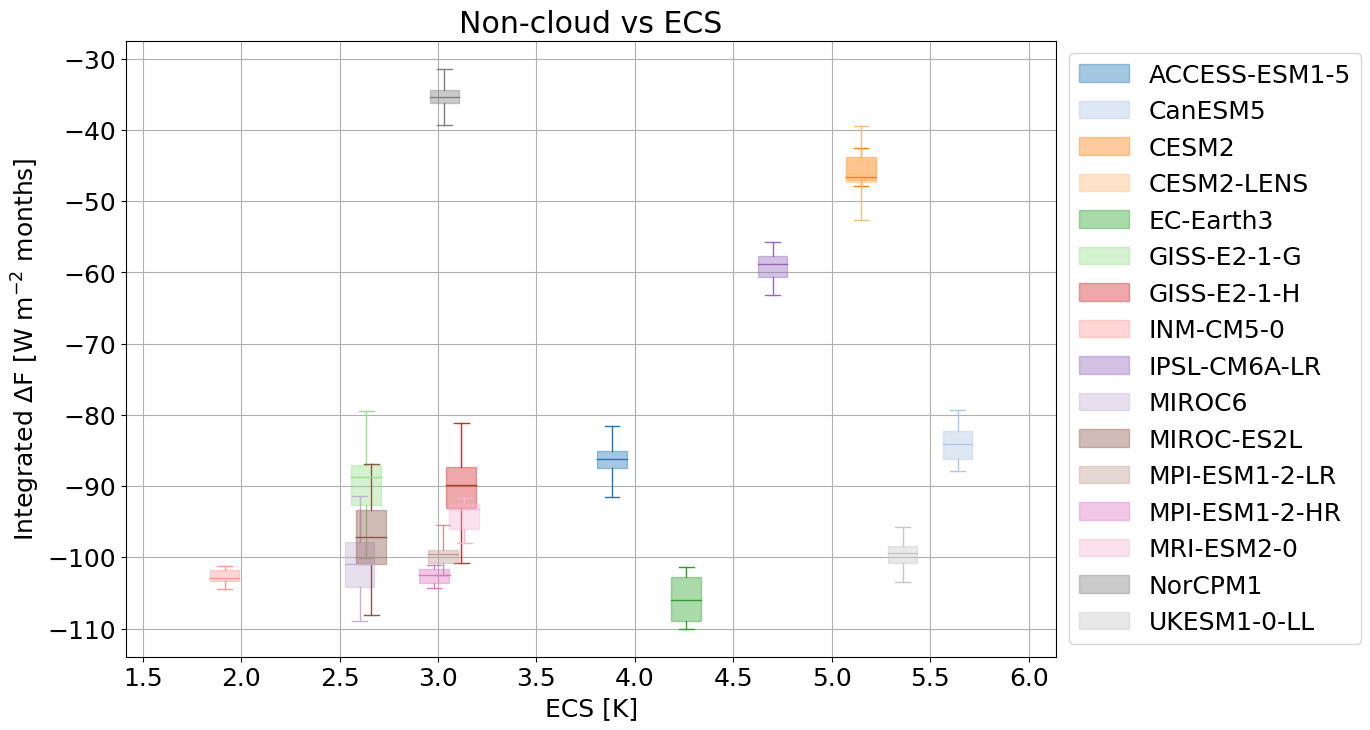

In [10]:
elements = []
labels = []

fig = plt.figure(1)
for n, name in enumerate(models):
    b = plt.boxplot(aprp_dict[name].compute().data,
                positions=[ecs_dict[name]],
                whis=(0, 100),
                labels=[name],
                patch_artist=True,
                boxprops={"facecolor": colors[n], "alpha": 0.4, "color": colors[n]},
                medianprops={"color": colors[n]},
                whiskerprops={"color": colors[n]},
                capprops={"color": colors[n]})
    elements.append(b)
    labels.append(name)
    
plt.xticks(np.arange(1.5, 6.01, 0.5))
plt.gca().set_xticklabels(np.arange(1.5, 6.01, 0.5))
plt.grid()

plt.legend([element["boxes"][0] for element in elements], 
           [labels[idx] for idx,_ in enumerate(models)],
           loc='center left',
           bbox_to_anchor=(1, 0.5))

plt.ylabel("Integrated $\Delta$F [W m$^{-2}$ months]")
plt.xlabel("ECS [K]")
plt.title("Non-cloud vs ECS")

fig.savefig("../figures/aprp_noncld_vs_ECS_v2_20220419.png",
            bbox_inches="tight", dpi=150)

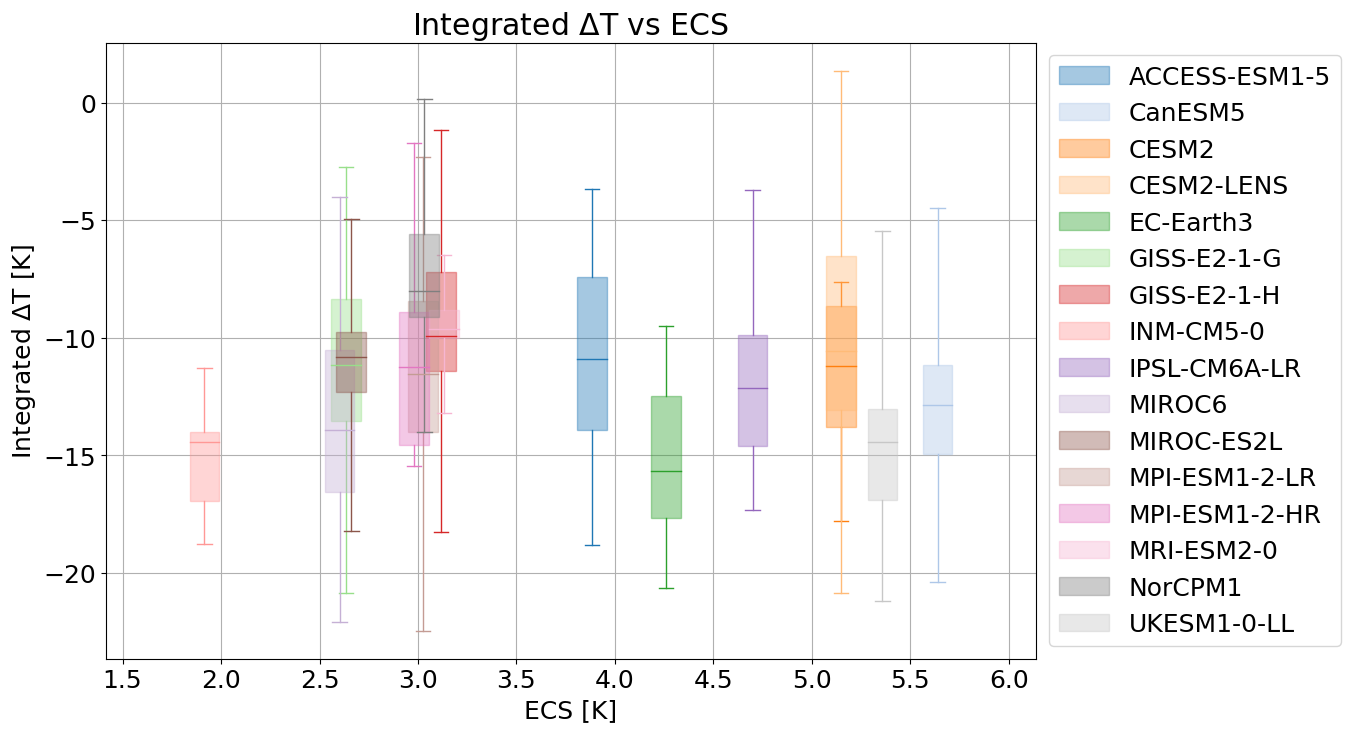

In [11]:
elements = []
labels = []

fig = plt.figure(1)
for n, name in enumerate(models):
    b = plt.boxplot(temp_dict[name].data,
                positions=[ecs_dict[name]],
                whis=(0, 100),
                labels=[name],
                patch_artist=True,
                boxprops={"facecolor": colors[n], "alpha": 0.4, "color": colors[n]},
                medianprops={"color": colors[n]},
                whiskerprops={"color": colors[n]},
                capprops={"color": colors[n]})
    elements.append(b)
    labels.append(name)
    
plt.xticks(np.arange(1.5, 6.01, 0.5))
plt.gca().set_xticklabels(np.arange(1.5, 6.01, 0.5))
plt.grid()

plt.legend([element["boxes"][0] for element in elements], 
           [labels[idx] for idx,_ in enumerate(models)],
           loc='center left',
           bbox_to_anchor=(1, 0.5))

plt.ylabel("Integrated $\Delta$T [K]")
plt.xlabel("ECS [K]")
plt.title("Integrated $\Delta$T vs ECS")

fig.savefig("../figures/temp_vs_ECS_20220419.png",
            bbox_inches="tight", dpi=150)

### Plot ratio vs ECS

### Compute correlation with all ensemble members

In [12]:
ecs_list = []
ratio_list = []

for n, name in enumerate(models):
    ratio = temp_dict[name].data/aprp_dict[name].data
    ens = len(ratio)
        
    [ecs_list.append(ecs_dict[name]) for n in range(ens)]
    [ratio_list.append(ratio[n]) for n in range(ens)]

ecs_arr = np.array(ecs_list)
ratio_arr = np.array(ratio_list)

corr, p = pearsonr(ecs_arr, ratio_arr)
print(f"Correlation = {corr:5.4f}")
print(f"p-value = {p}")

Correlation = 0.3361
p-value = 1.7158759524113503e-15


### Compute correlation with ensemble means

In [13]:
ecs_list = []
ratio_list = []

for n, name in enumerate(models):
    ratio = (temp_dict[name].data/aprp_dict[name]).mean("ensmem").data
        
    ecs_list.append(ecs_dict[name])
    ratio_list.append(ratio)

ecs_arr = np.array(ecs_list)
ratio_arr = np.array(ratio_list)

corr, p = pearsonr(ecs_arr, ratio_arr)
print(f"Correlation = {corr:5.4f}")
print(f"p-value = {p}")

Correlation = 0.5552
p-value = 0.025572840618015295


In [14]:
slope, intcpt, r, p, stderr = linregress(ratio_arr, ecs_arr)
print(f"Slope: {slope:5.4f}")
print(f"r: {r:5.4f}")
print(f"p: {p}")

x = np.arange(0, 0.45, 0.01)
y = slope*x + intcpt

Slope: 14.4488
r: 0.5552
p: 0.02557284061801525


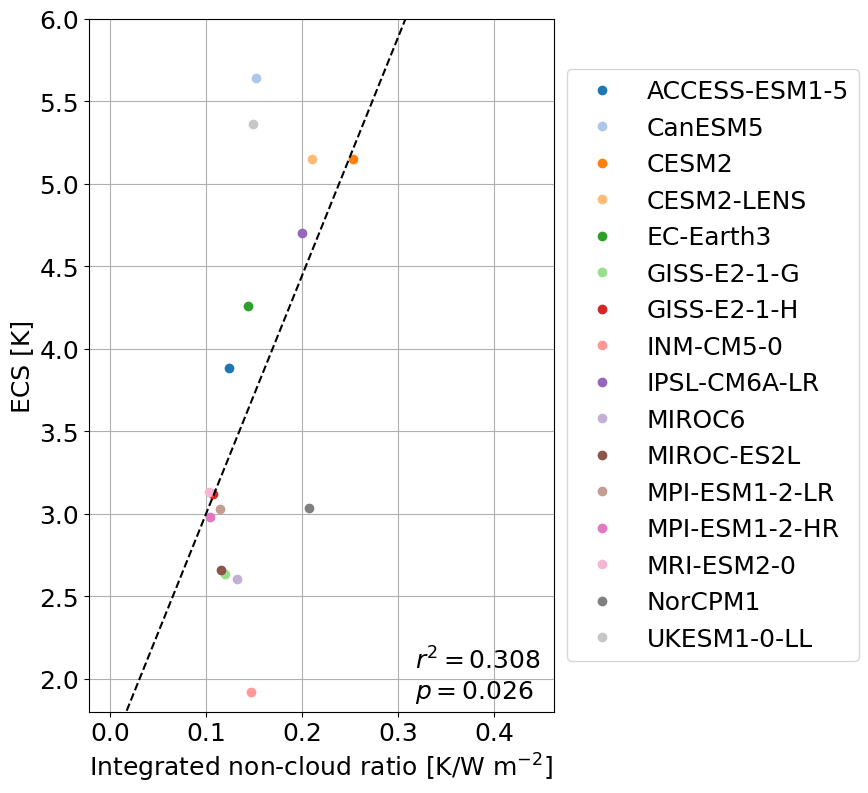

In [16]:
fig = plt.figure(1, figsize=(6, 9))
colors = pl.cm.tab20.colors
for n, model in enumerate(models):
    plt.plot(ratio_arr[n], ecs_arr[n], "o", color=colors[n], label=model)
plt.plot(x, y, "k--")
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.grid()
plt.ylim(1.8, 6)
plt.ylabel("ECS [K]")
plt.xlabel("Integrated non-cloud ratio [K/W m$^{-2}$]")
plt.annotate(f"$r^2=${r**2:5.3f}\n$p=${p:5.3f}",
             xy=(0.7, 0.02),
             xycoords="axes fraction")

fig.savefig("../figures/aprp_noncld_ensmean_vs_ecs.png",
            bbox_inches="tight", dpi=150)

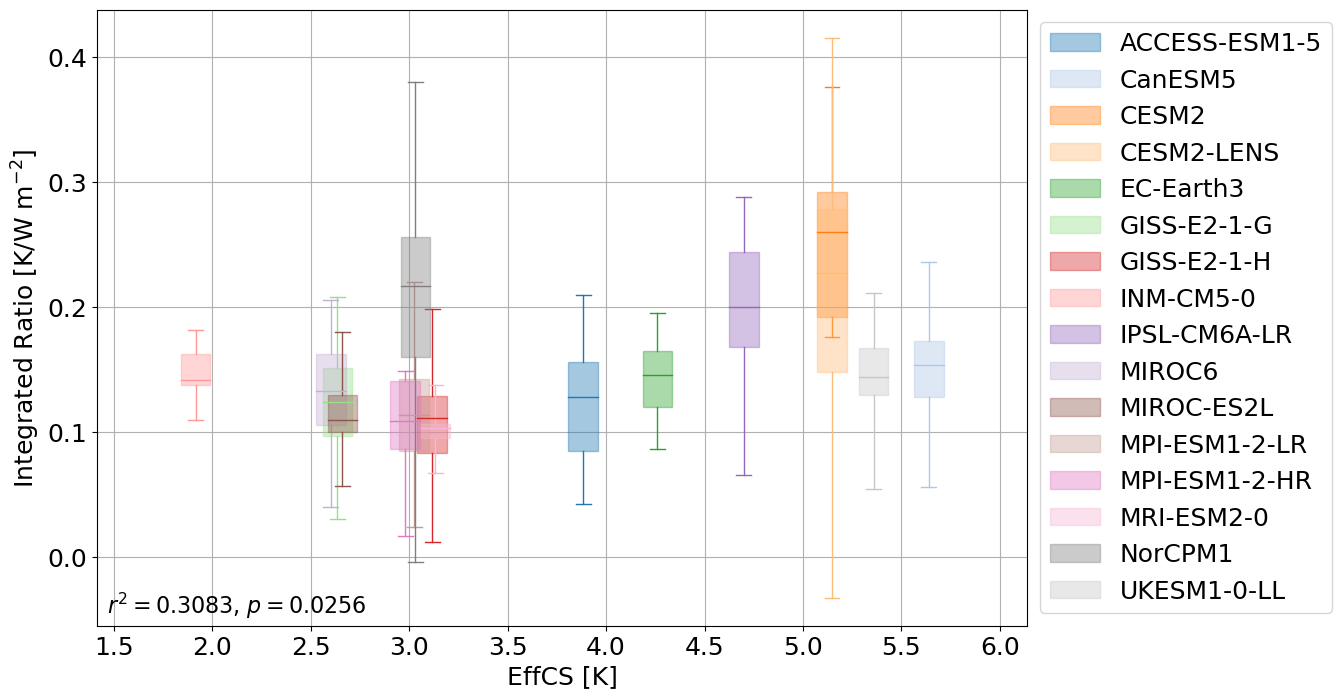

In [17]:
elements = []
labels = []

fig = plt.figure(1, facecolor="white")
for n, name in enumerate(models):

    ratio = temp_dict[name].data/aprp_dict[name].data,
    b = plt.boxplot(ratio,
                positions=[ecs_dict[name]],
                whis=(0, 100),
                labels=[name],
                patch_artist=True,
                boxprops={"facecolor": colors[n], "alpha": 0.4, "color": colors[n]},
                medianprops={"color": colors[n]},
                whiskerprops={"color": colors[n]},
                capprops={"color": colors[n]})
    elements.append(b)
    labels.append(name)
    
plt.annotate(f"$r^2=${r**2:5.4f}, $p=${p:5.4f}",
             xy=(0.01, 0.02),
             xycoords="axes fraction",
             fontsize=16)

plt.xticks(np.arange(1.5, 6.01, 0.5))
plt.gca().set_xticklabels(np.arange(1.5, 6.01, 0.5))
plt.grid()

plt.legend([element["boxes"][0] for element in elements], 
           [labels[idx] for idx,_ in enumerate(models)],
           loc='center left',
           bbox_to_anchor=(1, 0.5))

plt.ylabel("Integrated Ratio [K/W m$^{-2}$]")
plt.xlabel("EffCS [K]")
# plt.title("Integrated Ratio vs ECS")

fig.savefig("../figures/aprp_noncld_ratio_vs_ECS_20220419.png",
            bbox_inches="tight", dpi=150,
            facecolor=fig.get_facecolor())

### Load OHU data to plot in panel alongside APRP non-cld

In [23]:
import pickle as pkl

with open("ohu_data_integrated.pkl", "rb") as f:
    anom_dict_ohu, int_dict_ohu = pkl.load(f)

In [24]:
# Drop CESM2-LENS for OHU since we don't have it yet
models2 = models.copy()
models2.remove("CESM2")

### Compute correlation of ratio with OHU

In [29]:
# Assign ensemble members to CESM2-LENS so that they match up
cdir = "../data/processed/CESM2-LENS/historical"
cfile = "TREFHT_CESM2-LENS_historical_ens_tseries_globmean_198001-201412.nc"
ncc = os.path.join(cdir, cfile)

ds = xr.open_dataset(ncc)
cesm_ensmem = ds["ensmem"].data
anom_dict_ohu["CESM2-LENS"] = anom_dict_ohu["CESM2-LENS"].assign_coords(ensmem=cesm_ensmem)

### Correlation for all ensemble members

In [30]:
ohu_arr = []
ratio_arr = []

for name in models2:
    ratio = temp_dict[name]/aprp_dict[name]
    if name[:4] == "GISS":
        test = anom_dict_ohu[name].sum("time")
        ratio = ratio.sel(ensmem=test.ensmem)
    else:
        da = anom_dict_ohu[name].sel(ensmem=ratio.ensmem)
        test = da.sum("time").data
        
    [ohu_arr.append(val) for val in test]
    [ratio_arr.append(float(val.data)) for val in ratio]
    
slope_o, intcpt_o, r_o, p_o, std_err_o = linregress(ratio_arr, ohu_arr)

print("Correlation of Ratio vs OHU")
print(f"\nr^2 = {r_o:5.3f}")
print(f"\np = {p_o}")

Correlation of Ratio vs OHU

r^2 = 0.330

p = 7.577835961283416e-14


### Correlation for ensemble mean

In [31]:
ohu_arr = []
ratio_arr = []

for name in models2:
    print(name)
    ratio = temp_dict[name]/aprp_dict[name]
    if name[:4] == "GISS":
        test = anom_dict_ohu[name].sum("time")
        ratio = ratio.sel(ensmem=test.ensmem)
        test = test.mean("ensmem")
    else:
        da = anom_dict_ohu[name].sel(ensmem=ratio.ensmem).mean("ensmem")
        test = da.sum("time").data
        
    ratio = ratio.mean("ensmem").data
        
    ohu_arr.append(test)
    ratio_arr.append(ratio)
    
slope_o, intcpt_o, r_o, p_o, std_err_o = linregress(ratio_arr, ohu_arr)

print("Correlation of Ratio vs OHU")
print(f"\nr^2 = {r_o:5.3f}")
print(f"\np = {p_o}")

ACCESS-ESM1-5
CanESM5
CESM2-LENS
EC-Earth3
GISS-E2-1-G
GISS-E2-1-H
INM-CM5-0
IPSL-CM6A-LR
MIROC6
MIROC-ES2L
MPI-ESM1-2-LR
MPI-ESM1-2-HR
MRI-ESM2-0
NorCPM1
UKESM1-0-LL
Correlation of Ratio vs OHU

r^2 = 0.585

p = 0.022053941202949425


### Plot APRP non-cld ratio alongside OHU results for paper

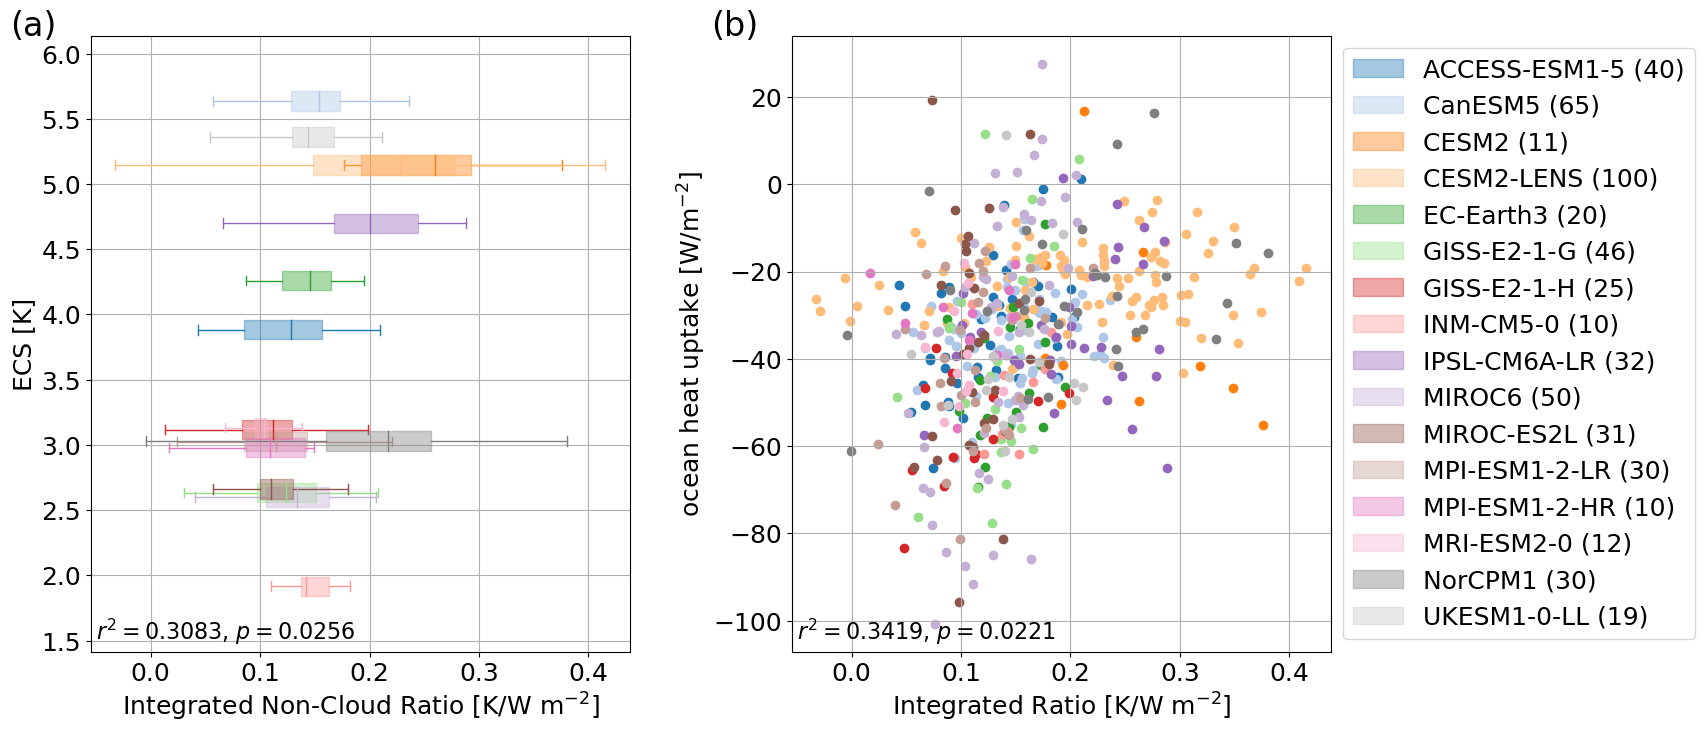

In [32]:
elements = []
labels = []

fig, (ax1, ax2) = plt.subplots(1, 2, facecolor="white",
                               figsize=(16, 8))
for n, name in enumerate(models):

    ratio = temp_dict[name]/aprp_dict[name]
    ens = ratio.size
    b = ax1.boxplot(ratio,
                    vert=False,
                    positions=[ecs_dict[name]],
                    whis=(0, 100),
                    labels=[name],
                    patch_artist=True,
                    boxprops={"facecolor": colors[n], "alpha": 0.4, "color": colors[n]},
                    medianprops={"color": colors[n]},
                    whiskerprops={"color": colors[n]},
                    capprops={"color": colors[n]})
    elements.append(b)
    labels.append(f"{name} ({ens})")
    
    da = anom_dict_ohu[name]
    if name == "EC-Earth3":
        da = da.sel(ensmem=temp_dict[name].ensmem)
    odata = da.sum("time")
    #tdata = int_dict_ohu[name]["temp"]
    #sdata = int_dict_ohu[name]["sw"]
    #ratio = tdata/sdata

    if name[:4] == "GISS":
        ratio = ratio.sel(ensmem=odata.ensmem.data)

    ax2.scatter(ratio, odata, color=colors[n], label=model)

ax1.annotate(f"$r^2=${r**2:5.4f}, $p=${p:5.4f}",
             xy=(0.01, 0.02),
             xycoords="axes fraction",
             fontsize=16)

ax2.annotate(f"$r^2=${r_o**2:5.4f}, $p=${p_o:5.4f}",
             xy=(0.01, 0.02),
             xycoords="axes fraction",
             fontsize=16)

ax1.set_yticks(np.arange(1.5, 6.01, 0.5))
ax1.set_yticklabels(np.arange(1.5, 6.01, 0.5))
ax1.grid()
ax2.grid()

#ax2.set_ylim(-1.2, 0.1)
#ax2.set_xlim(-0.1, 0.4)

ax2.legend([element["boxes"][0] for element in elements], 
           [labels[idx] for idx,_ in enumerate(models)],
           loc='center left',
           bbox_to_anchor=(1, 0.5))

ax1.set_ylabel("ECS [K]")

fig.subplots_adjust(wspace=0.3)

ax1.annotate("(a)", xy=(-0.15, 1), xycoords="axes fraction", fontsize=24)
ax2.annotate("(b)", xy=(-0.15, 1), xycoords="axes fraction", fontsize=24)

ax2.set_ylabel("ocean heat uptake [W/m$^{-2}$]")
ax2.set_xlabel("Integrated Ratio [K/W m$^{-2}$]")
ax1.set_xlabel("Integrated Non-Cloud Ratio [K/W m$^{-2}$]")

fig.savefig("../figures/aprp_noncld_ratio_with_OHU.png",
            bbox_inches="tight", dpi=150)

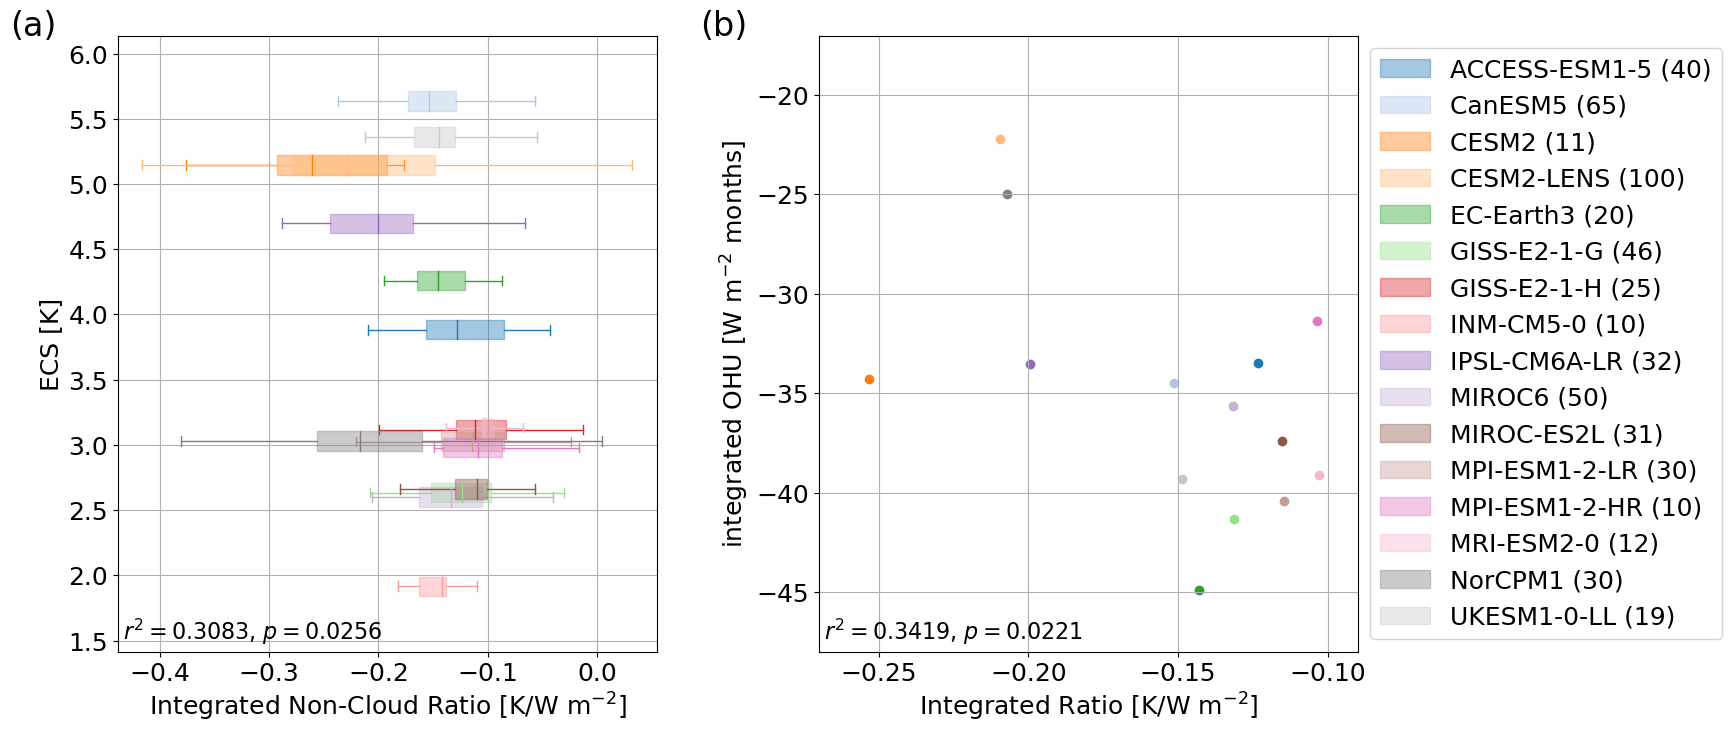

In [35]:
elements = []
labels = []

fig, (ax1, ax2) = plt.subplots(1, 2, facecolor="white",
                               figsize=(16, 8))
for n, name in enumerate(models):

    ratio = -temp_dict[name]/aprp_dict[name]
    ens = ratio.size
    b = ax1.boxplot(ratio,
                    vert=False,
                    positions=[ecs_dict[name]],
                    whis=(0, 100),
                    labels=[name],
                    patch_artist=True,
                    boxprops={"facecolor": colors[n], "alpha": 0.4, "color": colors[n]},
                    medianprops={"color": colors[n]},
                    whiskerprops={"color": colors[n]},
                    capprops={"color": colors[n]})
    elements.append(b)
    labels.append(f"{name} ({ens})")
    
    da = anom_dict_ohu[name]
    if name == "EC-Earth3":
        da = da.sel(ensmem=temp_dict[name].ensmem)
    odata = da.sum("time")

    if name[:4] == "GISS":
        ratio = ratio.sel(ensmem=odata.ensmem.data)
        
    ens = len(odata)

    odata = odata.mean("ensmem")
    ratio = ratio.mean("ensmem")
    
    ax2.scatter(ratio, odata, color=colors[n],
                label=f"{model} ({ens})")
    
ax1.annotate(f"$r^2=${r**2:5.4f}, $p=${p:5.4f}",
             xy=(0.01, 0.02),
             xycoords="axes fraction",
             fontsize=16)

ax2.annotate(f"$r^2=${r_o**2:5.4f}, $p=${p_o:5.4f}",
             xy=(0.01, 0.02),
             xycoords="axes fraction",
             fontsize=16)

ax1.set_yticks(np.arange(1.5, 6.01, 0.5))
ax1.set_yticklabels(np.arange(1.5, 6.01, 0.5))
ax1.grid()
ax2.grid()

ax2.set_ylim(-48, -17)
ax2.set_xlim(-0.27, -0.09)

handles = [element["boxes"][0] for element in elements]
namelist = [labels[idx] for idx,_ in enumerate(models)]

ax2.legend(handles, 
           namelist,
           loc='center left',
           bbox_to_anchor=(1, 0.5))

ax1.set_ylabel("ECS [K]")

fig.subplots_adjust(wspace=0.3)

ax1.annotate("(a)", xy=(-0.2, 1), xycoords="axes fraction", fontsize=24)
ax2.annotate("(b)", xy=(-0.22, 1), xycoords="axes fraction", fontsize=24)

ax2.set_ylabel("integrated OHU [W m$^{-2}$ months]")
ax2.set_xlabel("Integrated Ratio [K/W m$^{-2}$]")
ax1.set_xlabel("Integrated Non-Cloud Ratio [K/W m$^{-2}$]")

ax2.set_xticks(np.arange(-0.25, -0.099, 0.05))

fig.savefig("../figures/aprp_noncld_ratio_with_OHU_ensmean_no2lyr.png",
            bbox_inches="tight", dpi=150)